Download all UBX files (base station and two wing tips) into a working directory.

Run RTKLIB-qt-Linux-x64/RTKCONV_Qt-x86_64.AppImage and apply it to each UBX file

Run RTKLIB-qt-Linux-x64/RTKPOST_Qt-x86_64.AppImage and set "RINEX OBS: Base Station" to base.obs and "RINEX NAV..." to base.nav

Set "RINEX OBS: Rover" to wingtip.obs for each, set Settings1 Filter Type to "Combined" and execute to generate wingtip.pos file for each.  

We might want some very limited parsing of the UBX stream in the Hanglog3 android app to extract the strengths of the satellite signals in each channel.


Processing should be to run with a stick and GPS on either end  Then see what the .log file does

In [179]:
# Find what UBX records are the UBX file
fname = "/home/julian/data/ublox/barstickmotorway2/base_raw_201902081414.UBX"
fname = "/home/julian/data/ublox/barstickmotorway2/rover_raw_201902081413.UBX"
# (The 0x02 0x13 and 0x02 0x15 both appear; the 0x01 0x30 and 0x01 0x22 probably aren't needed)
fname = "/home/julian/data/ublox/barstickmotorway2/hdata-2019-02-08_14-14-33.ubx"
g = open(fname, "rb").read()
import collections
collections.Counter((hex(x[0]), hex(x[1]))  for x in g.split(b"\xb5\x62")  if len(x)>=2)


Counter({('0x1', '0x30'): 2633,
         ('0x1', '0x22'): 2633,
         ('0x2', '0x15'): 2634,
         ('0x2', '0x13'): 2138,
         ('0xc7', '0x34'): 1,
         ('0xc5', '0x0'): 1,
         ('0xa9', '0xd9'): 1,
         ('0x73', '0x41'): 1,
         ('0xf8', '0xf3'): 1,
         ('0x79', '0x3c'): 1,
         ('0x51', '0x18'): 1,
         ('0x4c', '0xa5'): 1,
         ('0x44', '0xe'): 1,
         ('0x58', '0x4'): 1,
         ('0x7f', '0x4c'): 1,
         ('0x45', '0x0'): 4})

In [172]:
k[0], k[1]

(b'',
 b'\x02\x13(\x00\x01\x88\x00\x00\x08\x07\x02\x00\xe0\x7f\x08\x9a\x00\x00\x00\x00\x00\x00\xe0?\xdc?\x00\x00\xfc\xd3\x7f\x00\xbb\xbb\x01\xc0W\x99\xb9\xbb\xf1;\xf8\xb8\xd7\x04')

In [173]:
import collections
collections.Counter((hex(x[0]), hex(x[1]))  for x in g.split(b"\xb5\x62")  if len(x)>=2)


Counter({('0x2', '0x13'): 5359,
         ('0x2', '0x15'): 2640,
         ('0x73', '0x41'): 1,
         ('0xa2', '0xea'): 1,
         ('0x27', '0xa2'): 1,
         ('0x95', '0x75'): 1,
         ('0x41', '0x63'): 1,
         ('0xa0', '0x41'): 1,
         ('0xa7', '0x10'): 1,
         ('0x74', '0x41'): 1,
         ('0xf9', '0x9c'): 1,
         ('0xc0', '0xa6'): 1,
         ('0x2d', '0x5e'): 1,
         ('0x30', '0xc'): 1,
         ('0x29', '0x44'): 1,
         ('0x31', '0x9e'): 1})

In [117]:
import pandas, math

lng0, lat0 = None, None
GPS_UTC_SECONDS_DIFFERENCE = -18
def loadpos(fname):
    global lng0, lat0
    w = pandas.read_csv(fname, skiprows=9, sep="\s+")
    w["time"] = pandas.to_datetime(w["GPST"]) + pandas.Timedelta(seconds=GPS_UTC_SECONDS_DIFFERENCE)
    w = w.set_index("time")
    
    earthrad = 6378137
    nyfac = 2*math.pi*earthrad/360
    if lng0 is None:
        lng0, lat0 = w[["longitude(deg)", "latitude(deg)"]].iloc[0]
    exfac = nyfac*math.cos(math.radians(lat0))
    w["x"] = (w["longitude(deg)"] - lng0)*exfac  
    w["y"] = (w["latitude(deg)"] - lat0)*nyfac
    w["z"] = w["height(m)"]

    return w

w1 = loadpos("/home/julian/data/ublox/barstickmotorway2/hdata-2019-02-08_14-14-33.pos")
w2 = loadpos("/home/julian/data/ublox/barstickmotorway2/rover_raw_201902081413.pos")

w1.columns

Index(['%', 'GPST', 'latitude(deg)', 'longitude(deg)', 'height(m)', 'Q', 'ns',
       'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)',
       'ratio', 'x', 'y', 'z'],
      dtype='object')

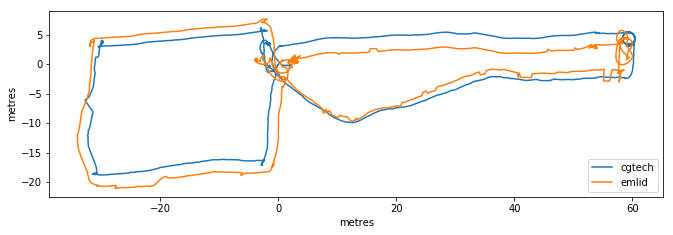

In [118]:

from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(11,6))
plt.axes().set_aspect('equal')
plt.plot(w1.x, w1.y, label="cgtech")
plt.plot(w2.x, w2.y, label="emlid")
plt.ylabel("metres")
plt.xlabel("metres")
plt.legend()
plt.savefig("2d.png")

In [119]:
import numpy, scipy.optimize
d2 = pandas.DataFrame({ "x1":w1.x, "y1":w1.y, "z1":w1.z, 
                        "x2":w2.x, "y2":w2.y, "z2":w2.z, 
                        "w1good":(w1.Q != 5) & (w1.ns >= 8),
                        "w2good":(w2.Q != 5) & (w2.ns >= 8)})
d2 = d2.dropna()
d2 = d2[d2.w1good & d2.w2good]

In [120]:
def f(X):
    dl = (d2.x1 - d2.x2 - X[0])**2 + (d2.y1 - d2.y2 - X[1])**2 + (d2.z1 - d2.z2 - X[2])**2
    #return numpy.sqrt(dl).std()
    return sum((numpy.sqrt(dl) - 2.3)**2)
r = scipy.optimize.minimize(f, (0, 0, 0))
print(r.x)
def f(X):
    dl = (d2.x1 - d2.x2 - X[0])**2 + (d2.y1 - d2.y2 - X[1])**2 + (d2.z1 - d2.z2 - X[2])**2
    return numpy.sqrt(dl).std()
r = scipy.optimize.minimize(f, (0, 0, 0))
r.x

[0.07703064 0.64008529 0.02154476]


array([ 0.09477811,  0.63975342, -0.63925046])

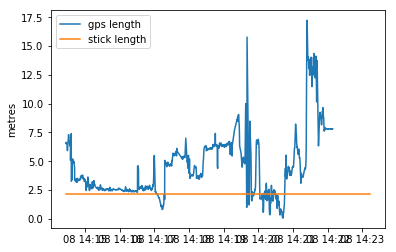

In [146]:
X = (0,0,-1.4)
dl = (d2.x1 - d2.x2 - X[0])**2 + (d2.y1 - d2.y2 - X[1])**2 + (d2.z1 - d2.z2 - X[2])**2
plt.plot(dl, label="gps length")
s = w1.iloc[[0,-1]].copy()
s.x = 2.13
plt.plot(s.x, label="stick length")
plt.ylabel("metres")
plt.legend()
plt.savefig("stickleng.png")


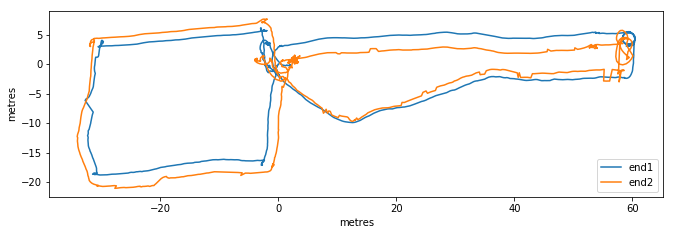

In [122]:
plt.figure(figsize=(11,6))
plt.axes().set_aspect('equal')
plt.plot(w1.x, w1.y, label="end1")
Xerr = (0,0,0)
plt.plot(w2.x+Xerr[0], w2.y+Xerr[1], label="end2")
plt.ylabel("metres")
plt.xlabel("metres")
plt.legend()
plt.savefig("2de.png")


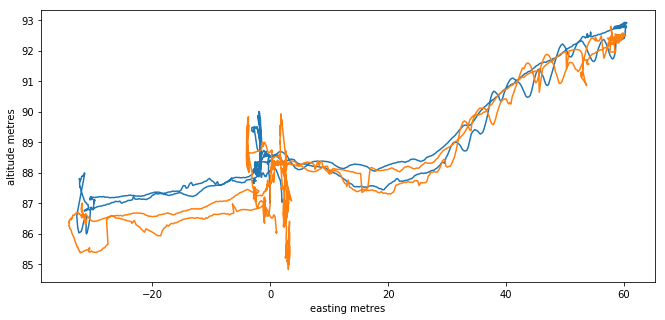

In [147]:
plt.figure(figsize=(11,5))
#plt.axes().set_aspect('equal')
plt.plot(w1.x, w1.z, label="cgtech")
plt.plot(w2.x, w2.z-1.5, label="emlid")
plt.ylabel("altitude metres")
plt.xlabel("easting metres")
plt.savefig("2dalt.png")


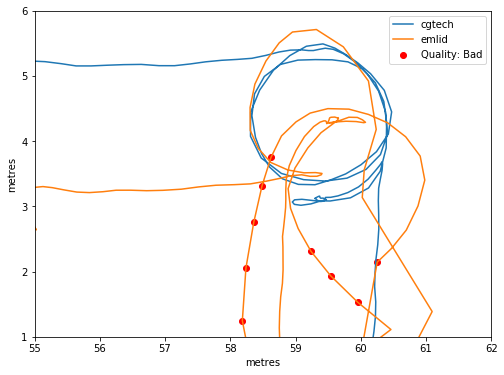

In [149]:
plt.figure(figsize=(11,6))
plt.axes().set_aspect('equal')
plt.plot(w1.x, w1.y, label="cgtech")
Xerr = (1,0,0)
plt.plot(w2.x+Xerr[0], w2.y+Xerr[1], label="emlid")
ss = w2[w2.Q > 2]
plt.scatter(ss.x+Xerr[0], ss.y+Xerr[1], color="red", label="Quality: Bad")
plt.xlim((55, 62))
plt.ylim((1, 6))

plt.ylabel("metres")
plt.xlabel("metres")
plt.legend()
plt.savefig("2dspincorner.png")


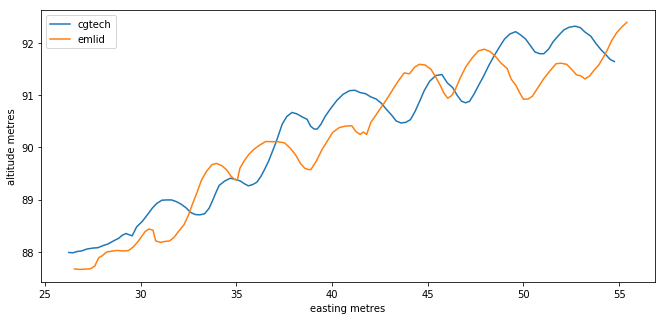

In [125]:
plt.figure(figsize=(11,5))
#plt.axes().set_aspect('equal')
#plt.plot(w1.x, w1.z, label="cgtech")
t0, t1 = w2.index[0], w2.index[-1]
t0, t1 = t0+pandas.Timedelta(seconds=417), t0+pandas.Timedelta(seconds=440)
g = w2[t0:t1]
plt.plot(w1[t0:t1].x, w1[t0:t1].z, label="cgtech")
plt.plot(g.x+Xerr[0], g.z-1.5, label="emlid")
plt.ylabel("altitude metres")
plt.xlabel("easting metres")
plt.legend()


53.412047056999995 -2.971923584
Setting knowndate 2019-02-08
should be same 2019-02-08 00:00:00 2019-02-08 00:00:00
badline End(77350,55310)

F:24918, Q:2327, V:2627, Z:47344, U:134, aV:182, aF:2635, aZ:52310, aQ:182
linAdifftime -495975.312886503 count 38001
Made for Q 2327 last index 2327
Setting new Rdatetime0 2019-02-08 14:03:54.797707526 with std 10.56
Made for V 2627 last index 2627
timeflightindexerror
53.412047056999995 -2.971923584
Made for aQ 182 last index 182
Setting aRdatetime0 2019-02-08 14:12:17.676000 from 2019-02-08 14:12:17.676000 with std 24.16
Made for F 24918 last index 24918
Made for aF 2635 last index 2635
BAD VALUES 615 [(52, 'Zt0009A600x16BBy0090z2E28aD3AEb0100cFFFCw0090x2E28yD3AEz0100s00\n'), (94, 'Zt0009A7E7xFFFEy0001zBBFBa9016b2800cAE2Ew0090x2E28yD3AEz0100s00\n'), (114, 'Zt0009A8C4xFFFByBB01z9016a2800bAE2Ec00D3w0090x2E28yD3AEz0100sFB\n')]
Made for Z 47344 last index 46729


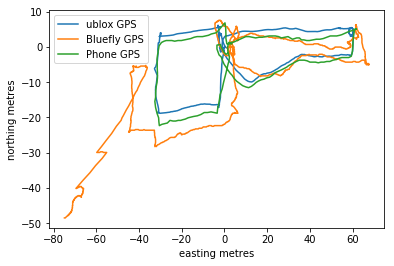

In [150]:
import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")
from hacktrack import loaders, utils
loaders.processQaddrelEN("setorigin", (lng0, lat0))
print(loaders.lat0, loaders.lng0)
fd = loaders.FlyDat("/home/julian/data/ublox/barstickmotorway2/hdata-2019-02-08_14-14-33.log")
print(loaders.lat0, loaders.lng0)
pQ = fd.pQ
pQ = pQ[(pQ.x**2<100000) & (pQ.y**2<100000)]

fd.LoadC("aQ")
fd.LoadC("F")
fd.LoadC("aF")
fd.LoadC("Z")

plt.plot((w1.x+w1.x)*0.5, (w1.y+w1.y)*0.5, label="ublox GPS")
plt.plot(pQ.x, pQ.y, label="Bluefly GPS")
plt.plot(fd.aQ.x, fd.aQ.y, label="Phone GPS")
plt.ylabel("northing metres")
plt.xlabel("easting metres")
plt.legend()
plt.savefig("extragps.png")


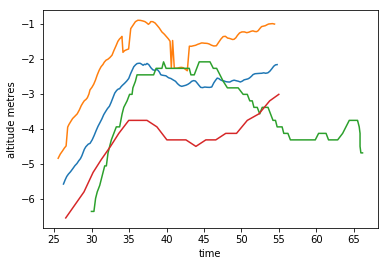

In [130]:
d = -27
d = 0

plt.plot(w1[t0:t1].x, w1[t0:t1].y)
g = w2[t0+pandas.Timedelta(seconds=d):t1]

plt.plot(g.x, g.y, label="emlid")
plt.ylabel("altitude metres")
plt.xlabel("time")

pQ = fd.pQ[t0+pandas.Timedelta(seconds=d):t1]
pQ = pQ[(pQ.x**2<100000) & (pQ.y**2<100000)]

plt.plot(pQ.x, pQ.y, label="bluefly alt")
aQ = fd.aQ[t0+pandas.Timedelta(seconds=d):t1]
plt.plot(aQ.x, aQ.y, label="phone gps alt")


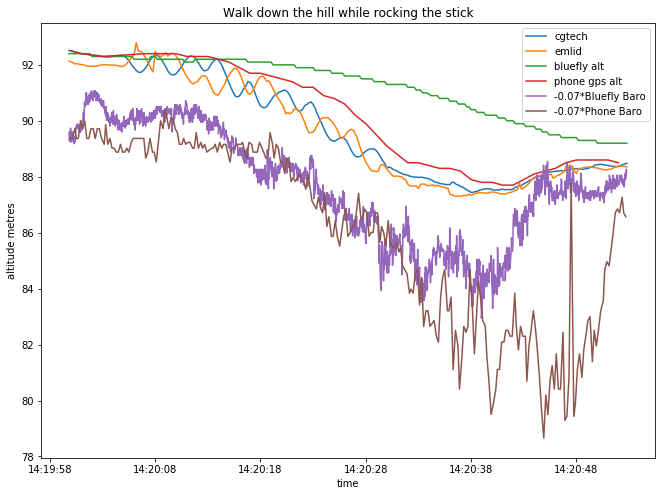

In [161]:
plt.figure(figsize=(11,8))
plt.title("Walk down the hill while rocking the stick")
#plt.axes().set_aspect('equal')
#plt.plot(w1.x, w1.z, label="cgtech")
t0, t1 = w2.index[0], w2.index[-1]
t0, t1 = t0+pandas.Timedelta(seconds=417-10), t0+pandas.Timedelta(seconds=440+20)
g = w2[t0:t1]
plt.plot(w1[t0:t1].z, label="cgtech")
plt.plot(g.z-1.5, label="emlid")
plt.ylabel("altitude metres")
plt.xlabel("time")

pQ = fd.pQ[t0:t1]
pQ = pQ[pQ.x>0]
plt.plot(pQ.alt+51, label="bluefly alt")

aQ = fd.aQ[t0:t1]
plt.plot(aQ.alt+56, label="phone gps alt")

Pr = fd.pF.Pr[t0:t1]
Pr = Pr[Pr<99500]
plt.plot((98060-Pr)*0.07+84, label="-0.07*Bluefly Baro")

Pr = fd.aF.Pr[t0:t1]
Pr = Pr[Pr>98250]
plt.plot((98060-Pr)*0.07+104, label="-0.07*Phone Baro")

#(fd.pZ[t0:t1].pitch+100).plot()
plt.legend()
plt.savefig("walkslope.png")


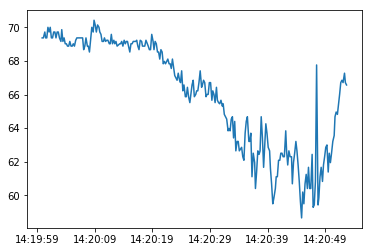

In [157]:
Pr = fd.aF.Pr[t0:t1]
Pr = Pr[Pr>98250]
plt.plot((98060-Pr)*0.07+84, label="-0.07*Baro")


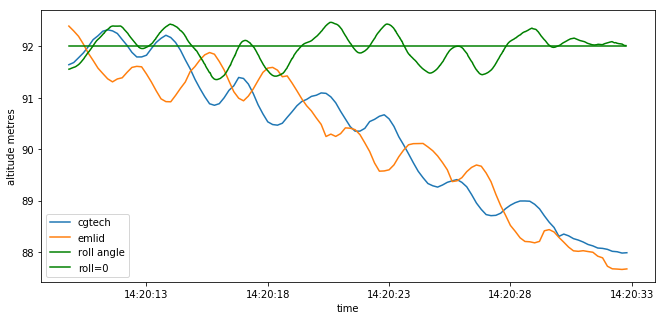

In [162]:
plt.figure(figsize=(11,5))
t0, t1 = w2.index[0], w2.index[-1]
t0, t1 = t0+pandas.Timedelta(seconds=417), t0+pandas.Timedelta(seconds=440)
g = w2[t0:t1]
plt.plot(w1[t0:t1].z, label="cgtech")
plt.plot(g.z-1.5, label="emlid")
plt.ylabel("altitude metres")
plt.xlabel("time")
plt.plot(fd.pZ[t0:t1].roll*0.02+92, label="roll angle", color="green")
plt.plot([fd.pZ[t0:t1].index[0], fd.pZ[t0:t1].index[-1]], [92,92], label="roll=0", color="green")
plt.legend()
plt.savefig("rollang.png")

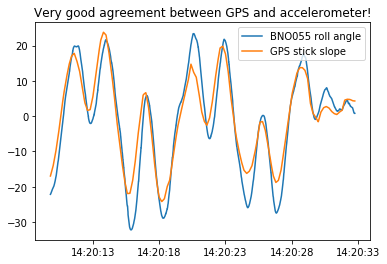

In [163]:
Roll = fd.pZ[t0:t1].roll

Z1 = utils.InterpT(Roll, w1[t0:t1].z)
Z2 = utils.InterpT(Roll, g.z)
plt.plot(Roll.index, Roll, label="BNO055 roll angle")
plt.plot((Z1-Z2+1.4)*20, label="GPS stick slope")
plt.title("Very good agreement between GPS and accelerometer!")
plt.legend()
plt.savefig("gpsaccel.png")


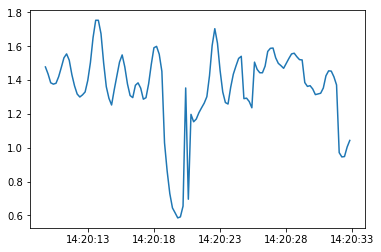

In [143]:
plt.plot(numpy.sqrt((w1[t0:t1].z - g.z+1.4)**2 + (w1[t0:t1].x - g.x)**2 + (w1[t0:t1].y - g.y)**2))

Timestamp('2019-02-08 14:20:10.805707526')